In [2]:
import random
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
from langchain_groq import ChatGroq  # Assuming you are using the langchain_groq package
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)

# Load datasets
X_train = np.load('FinalDataset/X_train.npy')
X_test = np.load('FinalDataset/X_test.npy')
y_train = np.load('FinalDataset/y_train.npy')
y_test = np.load('FinalDataset/y_test.npy')

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}
X_train shape:  (126, 500, 3)
X_test shape:  (54, 500, 3)
y_train shape:  (126,)
y_test shape:  (54,)


In [3]:
# Feature extraction and processing steps...

import tsfel

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_features = tsfel.time_series_features_extractor(cfg, X_train, verbose=1, fs=50)
X_test_features = tsfel.time_series_features_extractor(cfg, X_test, verbose=1, fs=50)

# Remove highly correlated features
correlated_features = tsfel.correlated_features(X_train_features)
X_train_filtered = X_train_features.drop(correlated_features, axis=1)
X_test_filtered = X_test_features.drop(correlated_features, axis=1)

# Remove low variance features
variance_selector = VarianceThreshold(threshold=0)
X_train_reduced = variance_selector.fit_transform(X_train_filtered)
X_test_reduced = variance_selector.transform(X_test_filtered)

# Normalize features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_test_normalized = scaler.transform(X_test_reduced)



*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


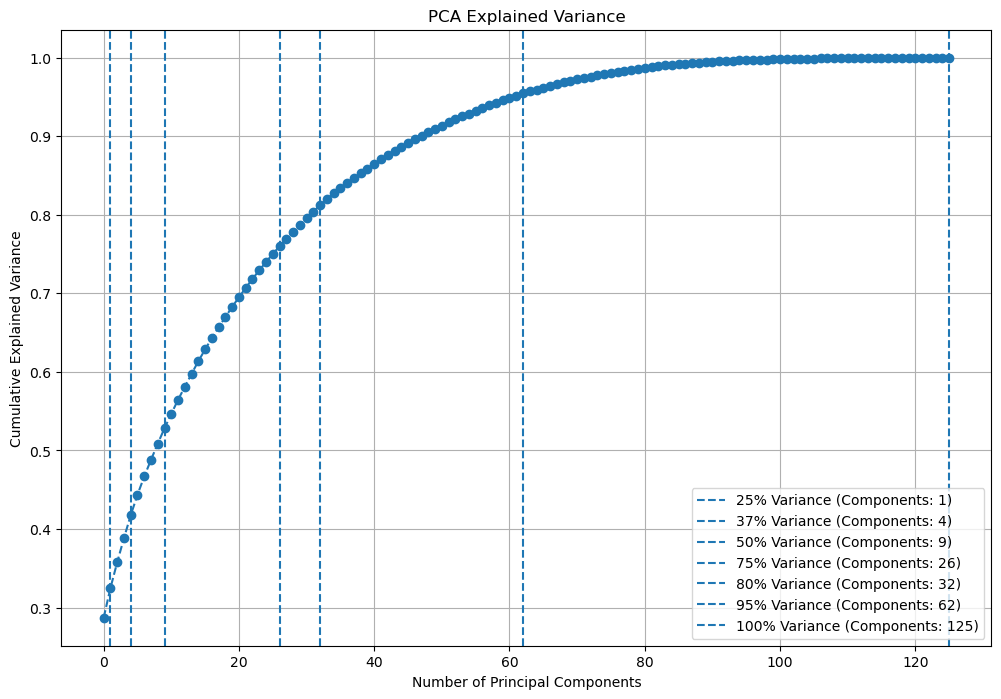

In [4]:
# Assuming X_train_normalized is already prepared
pca = PCA()
X_t_pca = pca.fit_transform(X_train_normalized)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Define thresholds
thresholds = [0.25,0.37, 0.50, 0.75, 0.80, 0.95, 1.00]
threshold_labels = ['25% Variance','37% Variance', '50% Variance', '75% Variance', '80% Variance', '95% Variance', '100% Variance']

# Find the number of components required to achieve each threshold
component_counts = [np.argmax(cumulative_explained_variance >= t) + 1 for t in thresholds]

# Plot the cumulative explained variance
plt.figure(figsize=(12, 8))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
for count, label in zip(component_counts, threshold_labels):
    plt.axvline(x=count, linestyle='--', label=f'{label} (Components: {count})')
    
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

X_train_pca shape:  (126, 26)
X_test_pca shape:  (54, 26)
PCA Explained Variance:  [0.28703436 0.03779494 0.03279629 0.03077342 0.02917736 0.02607404
 0.0231991  0.02130383 0.0204915  0.01976109 0.01826076 0.0178074
 0.01663801 0.01641085 0.01615834 0.01487508 0.0146513  0.01355321
 0.01306939 0.0129321  0.01210642 0.01193556 0.01146481 0.01087026
 0.01059893 0.01004073]
PCA Explained Variance Sum:  0.7497790801227849
Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------

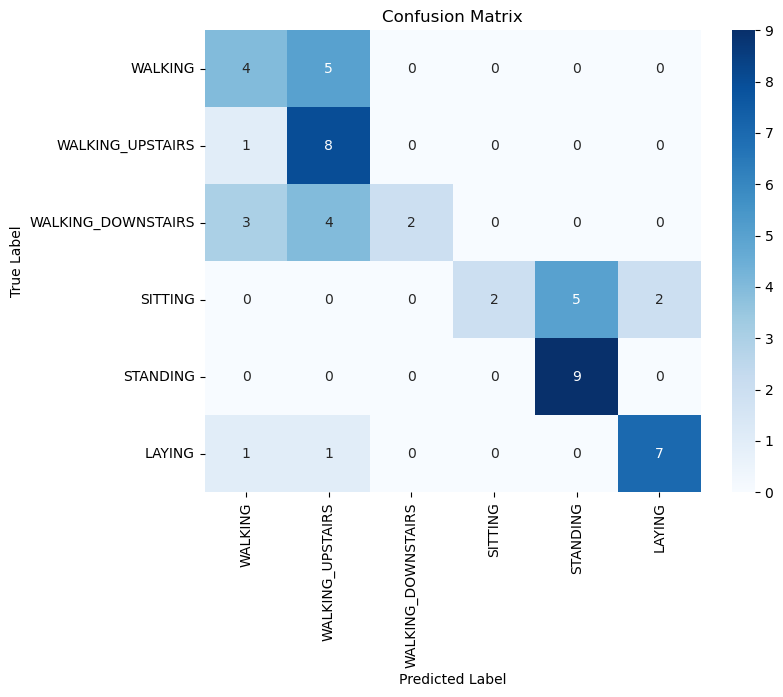

Total tokens used: 930999


In [8]:


import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns# Apply PCA
from sklearn.decomposition import PCA

# Define the number of PCA components to test
pca_n_components = [26]
for n in pca_n_components:
    pca = PCA(n_components=n)
    X_train_pca_20 = pca.fit_transform(X_train_normalized)
    X_test_pca_20 = pca.transform(X_test_normalized)

    print("X_train_pca shape: ", X_train_pca_20.shape)
    print("X_test_pca shape: ", X_test_pca_20.shape)

    import pandas as pd

    print("PCA Explained Variance: ", pca.explained_variance_ratio_)
    print("PCA Explained Variance Sum: ", sum(pca.explained_variance_ratio_))


    # Initialize token count
    token_count = 0

    def make_api_call(prompt):
        global token_count
        while True:
            try:
                response = llm.invoke(prompt)
                token_count += response.usage_metadata['total_tokens']  # Update token count with the response usage
                return response
            except Exception as e:
                print(f"Rate limit error: {e}. Retrying in 10 seconds...")
                time.sleep(10)  # Wait before retrying

    # Step 1: Set up your Groq API credentials and model
    Groq_Token = "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"
    model_name = "llama3.1-70b"
    llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

    # Step 2: Prepare your few-shot learning prompt
    #  Initialize necessary variables
    few_shot_indices = []
    samples_per_activity = 12  # Set the desired number of samples per activity for few-shot examples
    activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

    # Loop through the training data to select even samples
    for i, label in enumerate(y_train):
        if activity_count[label] < samples_per_activity:
            few_shot_indices.append(i)
            activity_count[label] += 1
        if all(count == samples_per_activity for count in activity_count.values()):
            break

    # Create the few-shot examples with even distribution
    few_shot_examples = [
        {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
    ]


    def create_few_shot_prompt(examples, query_input):
        # Description of the data and task
        description = ('''
            You are a highly trained human activity classification model.
            Each input is a vector containing numerical values that represent transformed features.
            The data is presented as comma-separated values in a list format.
            The data consists of 20 principal components extracted from the Human Activity Recognition dataset. 
            Your task is to analyze the given input vector and classify the human activity into one of the following categories:
            - 1: WALKING
            - 2: WALKING_UPSTAIRS
            - 3: WALKING_DOWNSTAIRS
            - 4: SITTING 
            - 5: STANDING
            - 6: LAYING
            Here are a few examples:\n'''
        )

        # Build the prompt with examples and the new query
        prompt = description
        for ex in examples:
            example_input = ",".join(map(str, ex['input']))
            prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n"
            
        query_input_str = ",".join(map(str, query_input))
        prompt += "Now, classify the following input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.\n"
        prompt += f"Input: [{query_input_str}]\nLabel: "
        return prompt

    # Step 3: Select 3 samples from each activity
    selected_indices = []
    samples_per_activity = 9
    activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

    for i, label in enumerate(y_test):
        if activity_count[label] < samples_per_activity:
            selected_indices.append(i)
            activity_count[label] += 1
        if all(count == samples_per_activity for count in activity_count.values()):
            break

    # Store predictions and true labels
    predictions = []
    true_labels = []

    # Step 4: Test the selected cases
    for idx in selected_indices:
        query_input = X_test_pca_20[idx].tolist()
        true_label = y_test[idx]
        prompt = create_few_shot_prompt(few_shot_examples, query_input)
        
        # Step 5: Make the API call using ChatGroq
        answer = make_api_call(prompt)
        
        # Store predictions and true labels
        predicted_label = int(answer.content.strip())
        
        predictions.append(predicted_label)
        true_labels.append(true_label)
        
        # Print the predicted and true labels
        print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
        print(f"Predicted label for the query input: {predicted_label}")
        print(f"True label for the query input: {true_label}")
        print("-" * 50)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Print token usage
    print(f"Total tokens used: {token_count}")


X_train_pca shape:  (126, 7)
X_test_pca shape:  (54, 7)
PCA Explained Variance:  [0.28703436 0.03779492 0.03279629 0.03077338 0.02917686 0.02607201
 0.02319478]
PCA Explained Variance Sum:  0.46684261184516934
Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted 

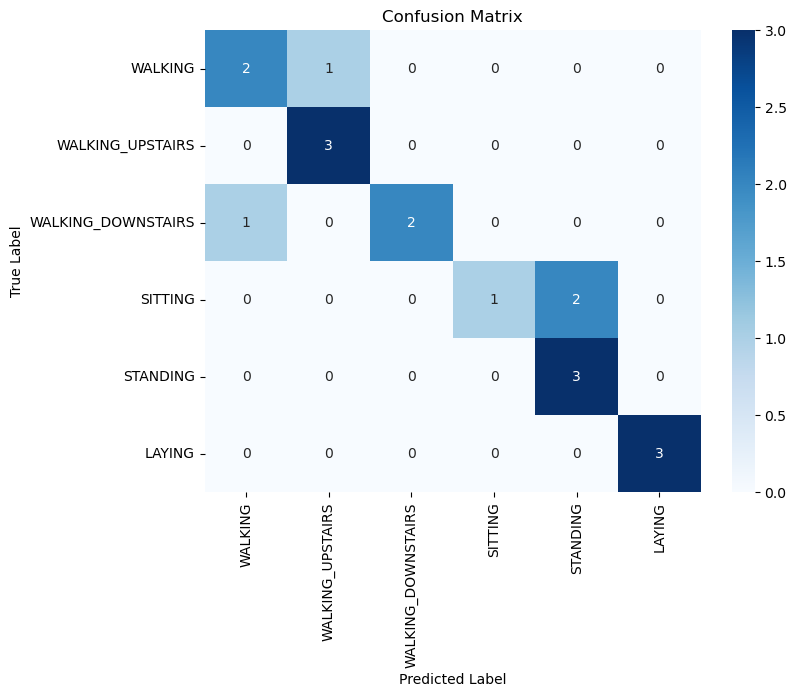

Total tokens used: 158785


In [23]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Define API keys and set up a round-robin index
Groq_Tokens = [
    "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",
    "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",
    "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"
]
api_key_index = 0  # To track the current API key

def get_next_api_key():
    global api_key_index
    key = Groq_Tokens[api_key_index]
    api_key_index = (api_key_index + 1) % len(Groq_Tokens)  # Rotate API key index
    return key

def make_api_call(prompt):
    global token_count
    while True:
        try:
            Groq_Token = get_next_api_key()  # Get the next API key
            model_name = "llama3.1-70b"
            llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
            
            response = llm.invoke(prompt)
            token_count += response.usage_metadata['total_tokens']  # Update token count with the response usage
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Define the number of PCA components to test
pca_n_components = [7]
for n in pca_n_components:
    pca = PCA(n_components=n)
    X_train_pca_20 = pca.fit_transform(X_train_normalized)
    X_test_pca_20 = pca.transform(X_test_normalized)

    print("X_train_pca shape: ", X_train_pca_20.shape)
    print("X_test_pca shape: ", X_test_pca_20.shape)

    print("PCA Explained Variance: ", pca.explained_variance_ratio_)
    print("PCA Explained Variance Sum: ", sum(pca.explained_variance_ratio_))

    # Initialize token count
    token_count = 0

    # Step 1: Prepare your few-shot learning prompt
    few_shot_indices = []
    samples_per_activity = 21  # Set the desired number of samples per activity for few-shot examples
    activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

    # Loop through the training data to select even samples
    for i, label in enumerate(y_train):
        if activity_count[label] < samples_per_activity:
            few_shot_indices.append(i)
            activity_count[label] += 1
        if all(count == samples_per_activity for count in activity_count.values()):
            break

    # Create the few-shot examples with even distribution
    few_shot_examples = [
        {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
    ]

    def create_few_shot_prompt(examples, query_input):
        description = ('''
            You are a highly trained human activity classification model.
            Each input is a vector containing numerical values that represent transformed features.
            The data is presented as comma-separated values in a list format.
            The data consists of 20 principal components extracted from the Human Activity Recognition dataset. 
            Your task is to analyze the given input vector and classify the human activity into one of the following categories:
            - 1: WALKING
            - 2: WALKING_UPSTAIRS
            - 3: WALKING_DOWNSTAIRS
            - 4: SITTING 
            - 5: STANDING
            - 6: LAYING
            Here are a few examples:\n'''
        )

        prompt = description
        for ex in examples:
            example_input = ",".join(map(str, ex['input']))
            prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n"
            
        query_input_str = ",".join(map(str, query_input))
        prompt += "Now, classify the following input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.\n"
        prompt += f"Input: [{query_input_str}]\nLabel: "
        return prompt

    # Step 3: Select 3 samples from each activity
    selected_indices = []
    samples_per_activity = 3
    activity_count = {i: 0 for i in range(1, 7)}

    for i, label in enumerate(y_test):
        if activity_count[label] < samples_per_activity:
            selected_indices.append(i)
            activity_count[label] += 1
        if all(count == samples_per_activity for count in activity_count.values()):
            break

    # Store predictions and true labels
    predictions = []
    true_labels = []

    # Step 4: Test the selected cases
    for idx in selected_indices:
        query_input = X_test_pca_20[idx].tolist()
        true_label = y_test[idx]
        prompt = create_few_shot_prompt(few_shot_examples, query_input)
        
        # Step 5: Make the API call using ChatGroq
        answer = make_api_call(prompt)
        
        # Store predictions and true labels
        predicted_label = int(answer.content.strip())
        
        predictions.append(predicted_label)
        true_labels.append(true_label)
        
        # Print the predicted and true labels
        print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
        print(f"Predicted label for the query input: {predicted_label}")
        print(f"True label for the query input: {true_label}")
        print("-" * 50)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Print token usage
    print(f"Total tokens used: {token_count}")


X_train_pca shape:  (126, 20)
X_test_pca shape:  (54, 20)
PCA Explained Variance:  [0.28703436 0.03779493 0.03279626 0.03077306 0.02917704 0.02607384
 0.02319797 0.02130197 0.02048824 0.01975318 0.01823666 0.01780103
 0.01662157 0.01638846 0.01615605 0.01483725 0.01460847 0.01352921
 0.01295232 0.0128771 ]
PCA Explained Variance Sum:  0.682398960572694
PCA Components: 20, Few-Shot Examples: 5
Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 5
Test Case 2 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 5
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 5
Test Case 4 (STANDIN

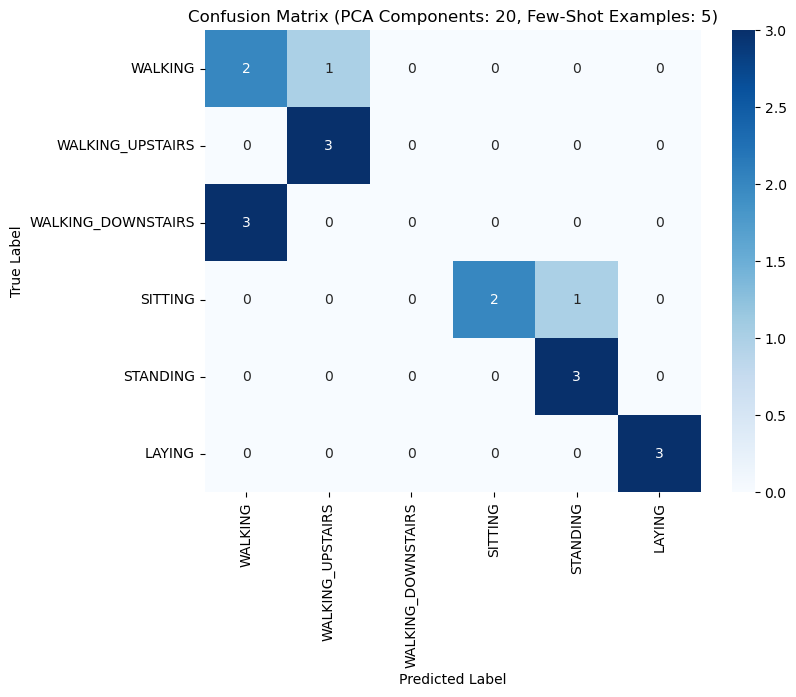

Total tokens used: 104878
PCA Components: 20, Few-Shot Examples: 8
Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 8
Test Case 2 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 8
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 8
Test Case 4 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 8
Test Case 5 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
PCA Componen

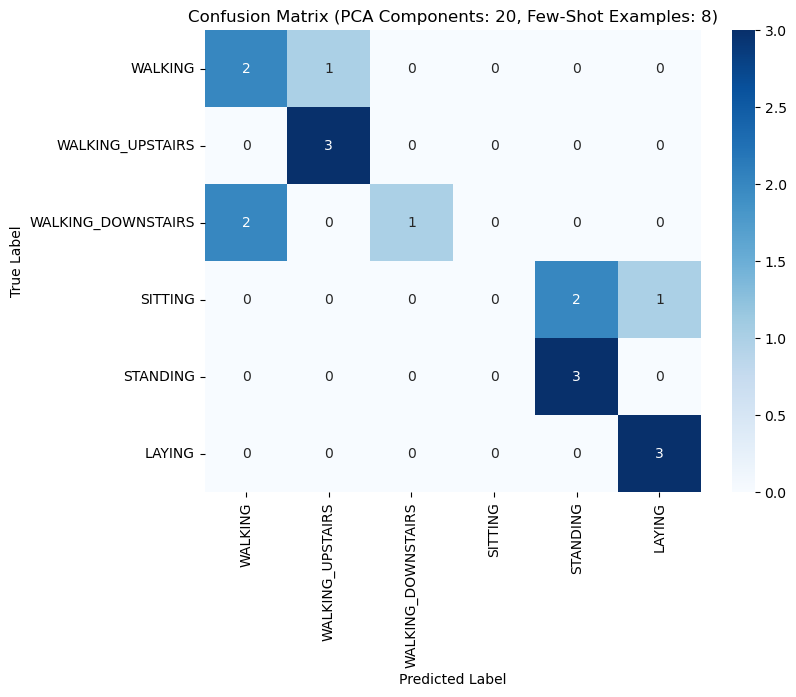

Total tokens used: 163504
PCA Components: 20, Few-Shot Examples: 10
Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 10
Test Case 2 (WALKING):
Predicted label for the query input: 3
True label for the query input: 1
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 10
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 10
Test Case 4 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
PCA Components: 20, Few-Shot Examples: 10
Test Case 5 (STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
PCA Com

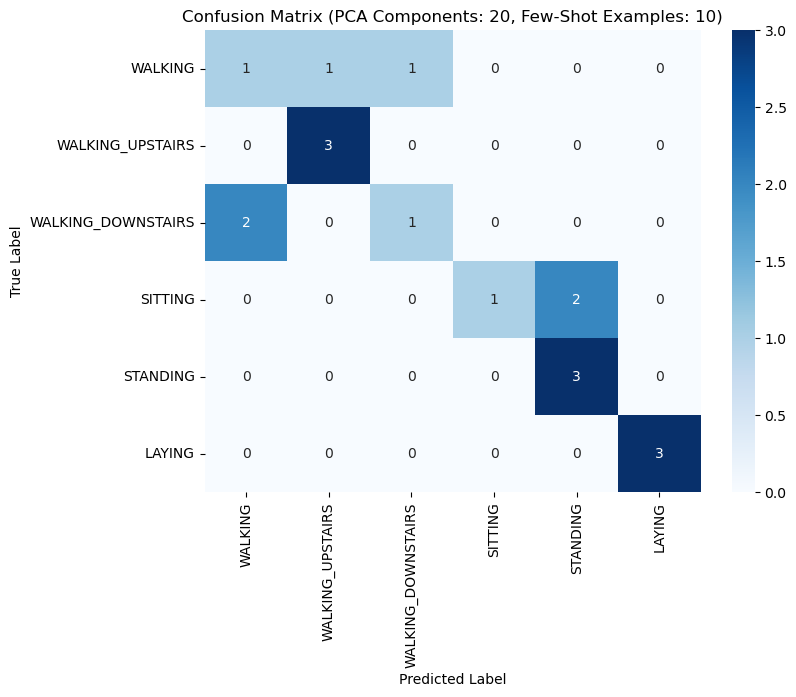

Total tokens used: 202708
X_train_pca shape:  (126, 26)
X_test_pca shape:  (54, 26)
PCA Explained Variance:  [0.28703436 0.03779493 0.03279629 0.03077339 0.02917742 0.02607408
 0.02319884 0.02130416 0.02049096 0.01975976 0.01825753 0.0178088
 0.0166376  0.01641297 0.01617031 0.01487305 0.01464677 0.01355885
 0.01306906 0.01289866 0.01210329 0.0119044  0.01142023 0.0108692
 0.01058974 0.00998041]
PCA Explained Variance Sum:  0.7496050519754289
PCA Components: 26, Few-Shot Examples: 5
Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 2
True label for the query input: 3
--------------------------------------------------
PCA Components: 26, Few-Shot Examples: 5
Test Case 2 (WALKING):
Predicted label for the query input: 2
True label for the query input: 1
--------------------------------------------------
PCA Components: 26, Few-Shot Examples: 5
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------

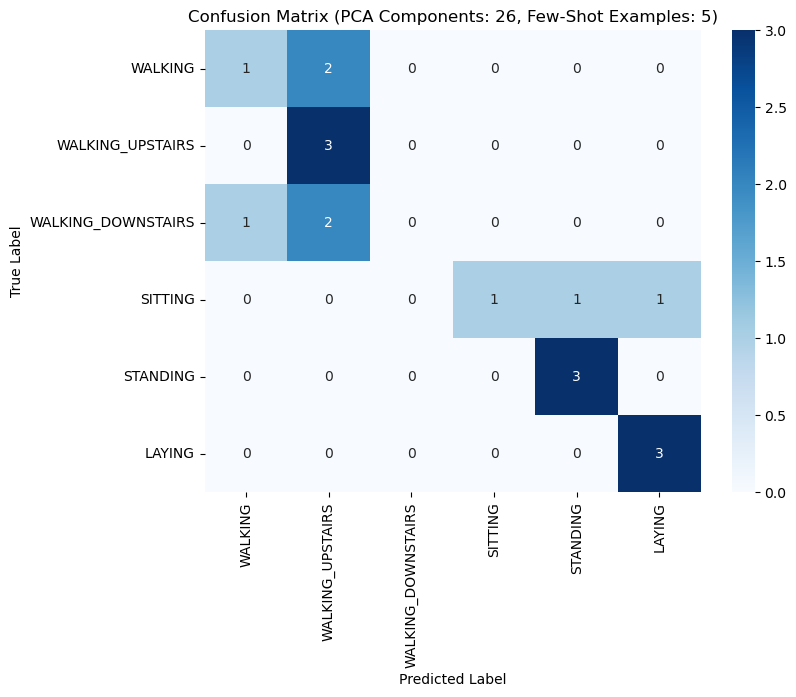

Total tokens used: 133771
PCA Components: 26, Few-Shot Examples: 8
Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
Rate limit error: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j5weppbregntctn3cv89rkfg` on : Limit 1000000, Used 997829, Requested 6614. Please try again in 6m23.857s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}. Retrying in 10 seconds...
PCA Components: 26, Few-Shot Examples: 8
Test Case 2 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
PCA Components: 26, Few-Shot Examples: 8
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------------------------------------
Rate

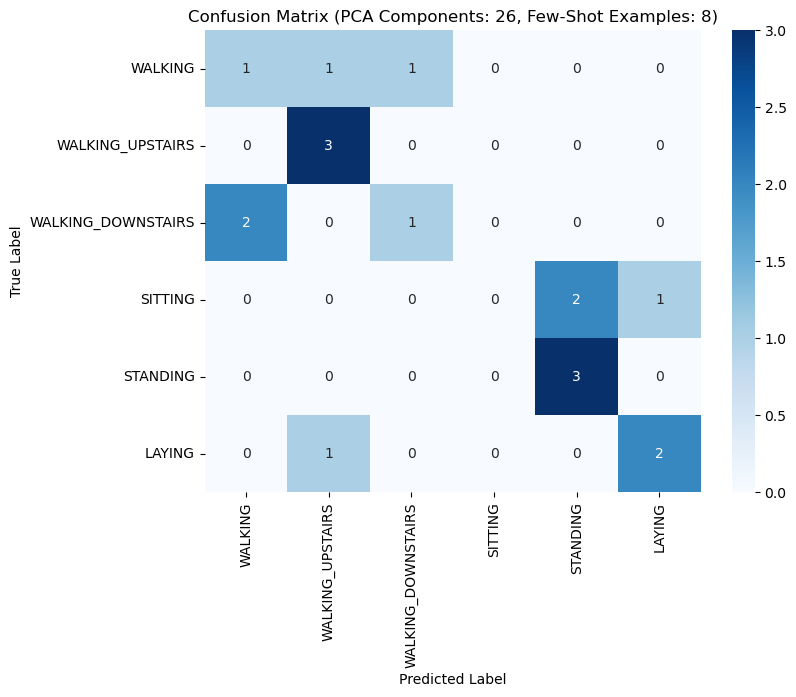

Total tokens used: 209371
PCA Components: 26, Few-Shot Examples: 10
Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
Rate limit error: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j5weppbregntctn3cv89rkfg` on : Limit 1000000, Used 995813, Requested 8181. Please try again in 5m45.001799999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}. Retrying in 10 seconds...
PCA Components: 26, Few-Shot Examples: 10
Test Case 2 (WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
PCA Components: 26, Few-Shot Examples: 10
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
----------------------------------------------

KeyboardInterrupt: 

In [ ]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Define API keys and set up a round-robin index
Groq_Tokens = [
    "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",
    "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",
    "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"
]
api_key_index = 0  # To track the current API key

def get_next_api_key():
    global api_key_index
    key = Groq_Tokens[api_key_index]
    api_key_index = (api_key_index + 1) % len(Groq_Tokens)  # Rotate API key index
    return key

def make_api_call(prompt):
    global token_count
    while True:
        try:
            Groq_Token = get_next_api_key()  # Get the next API key
            model_name = "llama3.1-70b"
            llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
            
            response = llm.invoke(prompt)
            token_count += response.usage_metadata['total_tokens']  # Update token count with the response usage
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Define the number of PCA components and few-shot examples to test
pca_n_components = [20, 26, 32]
few_shot_examples_counts = [5,8,10]  # Different counts of few-shot examples to test

for n in pca_n_components:
    pca = PCA(n_components=n)
    X_train_pca_20 = pca.fit_transform(X_train_normalized)
    X_test_pca_20 = pca.transform(X_test_normalized)

    print("X_train_pca shape: ", X_train_pca_20.shape)
    print("X_test_pca shape: ", X_test_pca_20.shape)

    print("PCA Explained Variance: ", pca.explained_variance_ratio_)
    print("PCA Explained Variance Sum: ", sum(pca.explained_variance_ratio_))

    for samples_per_activity in few_shot_examples_counts:
        # Initialize token count
        token_count = 0

        # Prepare your few-shot learning prompt
        few_shot_indices = []
        activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

        # Loop through the training data to select even samples
        for i, label in enumerate(y_train):
            if activity_count[label] < samples_per_activity:
                few_shot_indices.append(i)
                activity_count[label] += 1
            if all(count == samples_per_activity for count in activity_count.values()):
                break

        # Create the few-shot examples with even distribution
        few_shot_examples = [
            {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
        ]

        def create_few_shot_prompt(examples, query_input):
            description = ('''
                You are a highly trained human activity classification model.
                Each input is a vector containing numerical values that represent transformed features.
                The data is presented as comma-separated values in a list format.
                The data consists of 20 principal components extracted from the Human Activity Recognition dataset. 
                Your task is to analyze the given input vector and classify the human activity into one of the following categories:
                - 1: WALKING
                - 2: WALKING_UPSTAIRS
                - 3: WALKING_DOWNSTAIRS
                - 4: SITTING 
                - 5: STANDING
                - 6: LAYING
                Here are a few examples:\n'''
            )

            prompt = description
            for ex in examples:
                example_input = ",".join(map(str, ex['input']))
                prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n"
                
            query_input_str = ",".join(map(str, query_input))
            prompt += "Now, classify the following input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.\n"
            prompt += f"Input: [{query_input_str}]\nLabel: "
            return prompt

        # Select samples from each activity
        selected_indices = []
        activity_count = {i: 0 for i in range(1, 7)}

        for i, label in enumerate(y_test):
            if activity_count[label] < 3:  # Only 3 samples per activity for testing
                selected_indices.append(i)
                activity_count[label] += 1
            if all(count == 3 for count in activity_count.values()):
                break

        # Store predictions and true labels
        predictions = []
        true_labels = []

        # Test the selected cases
        for idx in selected_indices:
            query_input = X_test_pca_20[idx].tolist()
            true_label = y_test[idx]
            prompt = create_few_shot_prompt(few_shot_examples, query_input)
            
            # Make the API call using ChatGroq
            answer = make_api_call(prompt)
            
            # Store predictions and true labels
            predicted_label = int(answer.content.strip())
            
            predictions.append(predicted_label)
            true_labels.append(true_label)
            
            # Print the predicted and true labels
            print(f"PCA Components: {n}, Few-Shot Examples: {samples_per_activity}")
            print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
            print(f"Predicted label for the query input: {predicted_label}")
            print(f"True label for the query input: {true_label}")
            print("-" * 50)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)
        print(f"Accuracy: {accuracy:.2f}")

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix (PCA Components: {n}, Few-Shot Examples: {samples_per_activity})')
        plt.show()

        # Print token usage
        print(f"Total tokens used: {token_count}")


In [ ]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize token count
token_count = 0

def make_api_call(prompt):
    global token_count
    while True:
        try:
            response = llm.invoke(prompt)
            token_count += response.usage_metadata['total_tokens']  # Update token count with the response usage
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Set up your Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Function to generate a zero-shot prompt
# Function to generate a zero-shot prompt
def create_zero_shot_prompt(query_input, retained_features):
    """Generate a prompt for the model given the JSON formatted data and retained features."""
    # Combine features and their corresponding values in "column:value" format
    features_str = ', '.join([f"{feature}:{value}" for feature, value in zip(retained_features, query_input)])

    description = (f"""
    You are a highly trained human activity classification model.
    Each input is a vector containing numerical values that represent specific features of human activity data.
    The data is presented as pairs of column names and their corresponding values.

    The data consists of {N} features extracted from the Human Activity Recognition dataset. 
    Your task is to analyze the given input vector and classify the human activity into one of the following categories:
    - 1: WALKING
    - 2: WALKING_UPSTAIRS
    - 3: WALKING_DOWNSTAIRS
    - 4: SITTING 
    - 5: STANDING
    - 6: LAYING

    The initial data consisted of:
    - 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.

    Data Format:
    - Static activities tend to have very little variation in the accelerometer data, while dynamic activities tend to have more variation.
    - x axis is the vertical axis, z axis is forward direction, and y axis is the side direction.
    - Acceleration is measured in terms of g-force. At rest, the acceleration is 1 (representing gravity).

    The following input vector represents the selected features and their corresponding values: {features_str}

    Now, classify this input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.
    """)

    return description

# Step 3: Select 3 samples from each activity
selected_indices = []
samples_per_activity = 3
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the selected cases
for idx in selected_indices:
    query_input = X_test_important[idx].tolist()
    true_label = y_test[idx]
    prompt = create_zero_shot_prompt(query_input, top_feature_names)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print token usage
print(f"Total tokens used: {token_count}")
